In [71]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy

In [72]:
import sys
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 99/99 [00:00<00:00, 723.25it/s]


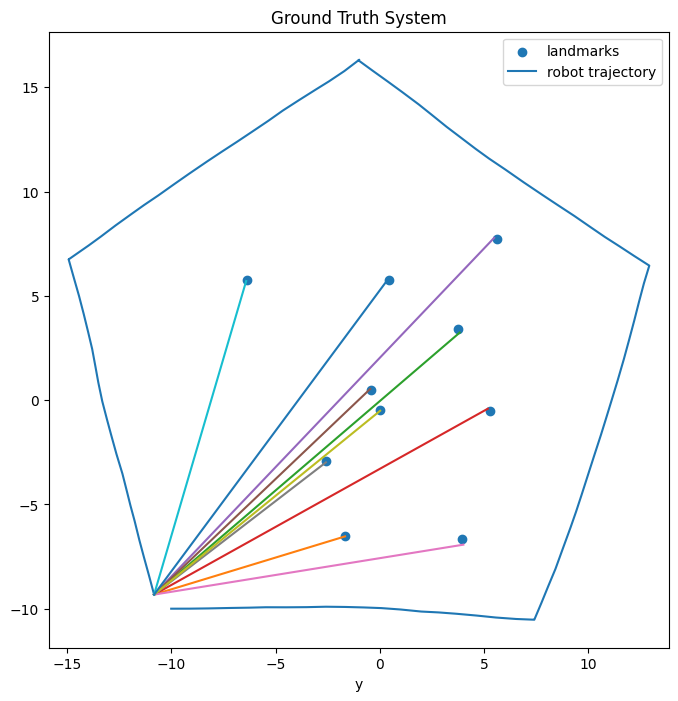

In [73]:
from example_systems import generate_SLAM_system
from helpers import vec

num_landmarks = 10
SLAM_system_gt = generate_SLAM_system(num_landmarks)

landmarks_gt = np.random.uniform(-8, 8, size=(2, num_landmarks))

T = 100
timesteps = np.arange(T) * SLAM_system_gt.delta_t

states_gt = np.zeros((T, 3 + 2*num_landmarks, 1))
controls = np.zeros((T, 3, 1))
measurements = np.zeros((T, 2*num_landmarks, 1))

# initial robot pose and true landmark locations
states_gt[0] = np.vstack([vec(-10.0, -10.0, 0.0), np.vstack(landmarks_gt.T.ravel())])

# robot control sequence
for i in range(5):  # drive in a pentagon
    controls[20*i:20*(i+1)] = vec(0.0, 0.9, 0.0)     # drive straight
    controls[20*i] = vec(2*np.pi/5, 0.0, 0.0)      # turn


for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = SLAM_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = SLAM_system_gt.query_measurement_model(x_next)
    measurements[t] = z

# Plot results
plt.figure(figsize=(8, 8))
plt.title("Ground Truth System")
plt.xlabel("x")
plt.xlabel("y")
plt.axis("equal")
plt.scatter(landmarks_gt[0], landmarks_gt[1], label="landmarks")
plt.plot(states_gt[:,0,0], states_gt[:,1,0], label="robot trajectory")

# plot some measurements
t = T-1
for i in range(num_landmarks):
    px, py, theta = states_gt[t,:3,0]
    b, r = measurements[t,2*i,0], measurements[t,2*i+1,0]
    plt.plot([px, px + r*np.cos(theta + b)], [py, py + r*np.sin(theta + b)])

plt.legend()

In [74]:
# Initial belief
initial_pose_estimate = states_gt[0,:3]
initial_pose_covariance = 0.001*np.eye(3)

# initial_landmarks_estimate = landmarks_gt.T.ravel().reshape(-1,1) + np.random.normal(0, 5.0, size=(2*num_landmarks, 1))
initial_landmarks_estimate = np.zeros((2*num_landmarks, 1))
initial_landmarks_covariance = 100*np.eye(2*num_landmarks)

initial_state_estimate = (
    np.vstack([initial_pose_estimate, initial_landmarks_estimate]),                     # initial mean
    scipy.linalg.block_diag(initial_pose_covariance, initial_landmarks_covariance)      # initial covariance
)

In [75]:
# Define the filter

from filters import ExtendedKalmanFilter

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
SLAM_system_approx = deepcopy(SLAM_system_gt)

SLAM_system_EKF = ExtendedKalmanFilter(SLAM_system_approx)

100%|██████████| 99/99 [00:13<00:00,  7.49it/s]


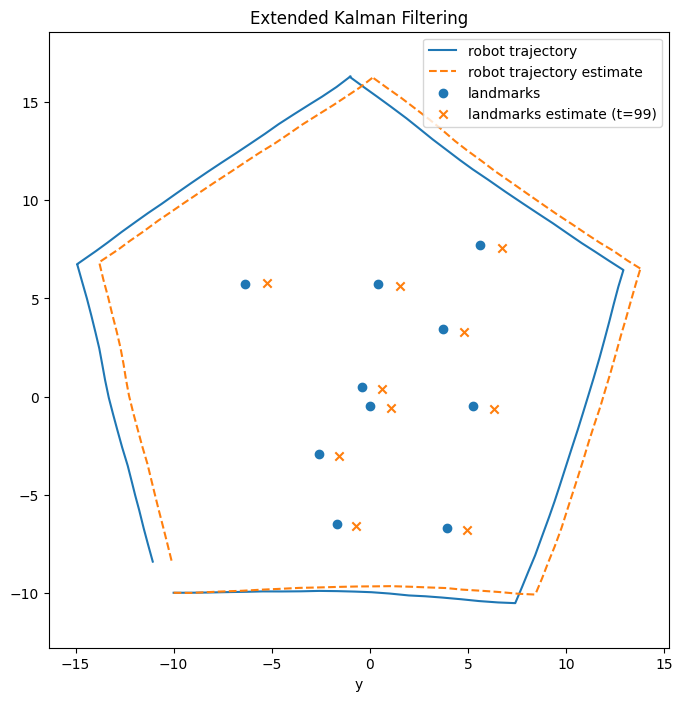

In [76]:
# Define the logger

from logger import SLAM_Logger

# Run the filter

# initial state belief
SLAM_system_EKF.initialize(*initial_state_estimate)

means_EKF = np.zeros((T, SLAM_system_approx.state_dim, 1))
covariances_EKF = np.zeros((T, SLAM_system_approx.state_dim, SLAM_system_approx.state_dim))

means_EKF[0] = SLAM_system_EKF.mean
covariances_EKF[0] = SLAM_system_EKF.covariance

# initialize the logger
EKF_log = SLAM_Logger(SLAM_system_EKF, T, '../data/log_EKF.txt')
EKF_log.initial_write(T,states_gt)

for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    SLAM_system_EKF.predict_step(u)
    SLAM_system_EKF.update_step(z)

    means_EKF[t] = SLAM_system_EKF.mean
    covariances_EKF[t] = SLAM_system_EKF.covariance

    EKF_log.iteration_write(u,z,SLAM_system_EKF.mean,SLAM_system_EKF.covariance,t)

# Plot results
t = T-1
plt.figure(figsize=(8, 8))
plt.title("Extended Kalman Filtering")
plt.xlabel("x")
plt.xlabel("y")
plt.axis("equal")
plt.plot(states_gt[:t,0,0], states_gt[:t,1,0], label="robot trajectory")
plt.plot(means_EKF[:t,0,0], means_EKF[:t,1,0], linestyle="--", label="robot trajectory estimate")
plt.scatter(landmarks_gt[0], landmarks_gt[1], label="landmarks")
plt.scatter(means_EKF[t, 3::2], means_EKF[t, 4::2], marker="x", label=f"landmarks estimate (t={t})")
plt.legend()

In [77]:
# Define the filter

from filters import UnscentedKalmanFilter

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
SLAM_system_approx = deepcopy(SLAM_system_gt)

SLAM_system_UKF = UnscentedKalmanFilter(SLAM_system_approx)

100%|██████████| 99/99 [00:00<00:00, 130.59it/s]

(100,)


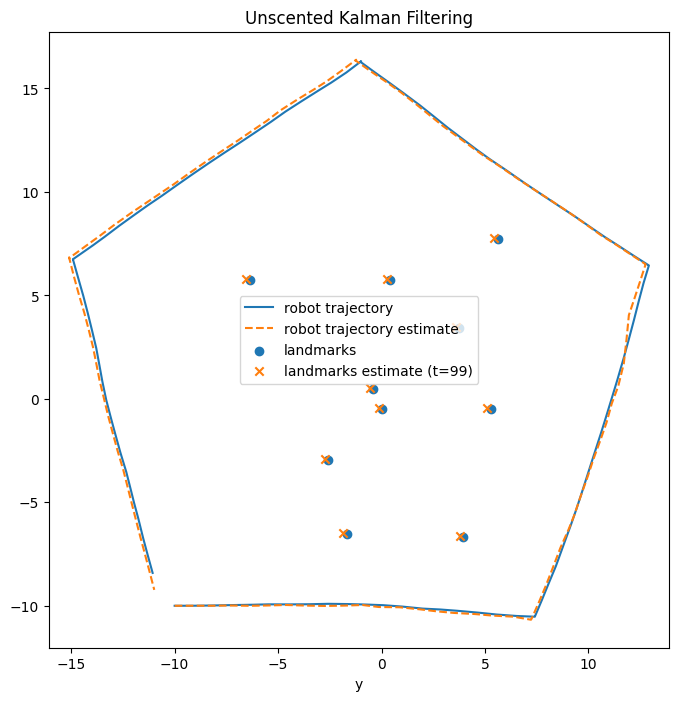

In [78]:
# Define the logger

#from logger import SLAM_Logger
from filterparser import SLAM_Parser

# Run the filter and log data

# initial state belief
SLAM_system_UKF.initialize(*initial_state_estimate)

means_UKF = np.zeros((T, SLAM_system_approx.state_dim, 1))
covariances_UKF = np.zeros((T, SLAM_system_approx.state_dim, SLAM_system_approx.state_dim))

means_UKF[0] = SLAM_system_UKF.mean
covariances_UKF[0] = SLAM_system_UKF.covariance

# initialize the logger
UKF_log = SLAM_Logger(SLAM_system_UKF, T, '../data/log_UKF.txt')
UKF_log.initial_write(T,states_gt)

for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    SLAM_system_UKF.predict_step(u)
    SLAM_system_UKF.update_step(z)

    means_UKF[t] = SLAM_system_UKF.mean
    covariances_UKF[t] = SLAM_system_UKF.covariance

    UKF_log.iteration_write(u,z,SLAM_system_UKF.mean,SLAM_system_UKF.covariance,t)

UKF_parser = SLAM_Parser('../data/log_UKF.txt')

u_matrix = UKF_parser.return_u()
z_matrix = UKF_parser.return_z()
mean_matrix = UKF_parser.return_mean()
gt_0 = UKF_parser.return_gt0()
landmark_0 = np.zeros((2,int((mean_matrix[0,:].size-3)/2)))
landmark_T = np.zeros((T,2,int((mean_matrix[0,:].size-3)/2)))

for i in range(0,int((mean_matrix[0,:].size-3)/2)):
    landmark_0[0,i] = gt_0[0,2*i+3]
    landmark_0[1,i] = gt_0[0,2*i+4]
    landmark_T[:,0,i] = mean_matrix[:,2*i+3]
    landmark_T[:,1,i] = mean_matrix[:,2*i+4]

gt_path = UKF_parser.return_gtp()

#print(landmark_0[0,:])
#print(landmark_0[1,:])
#print(mean_matrix[0,:].size)
#print(int((mean_matrix[0,:].size-3)/2))
#print(gt_0)

# Plot results
t = T-1
plt.figure(figsize=(8, 8))
plt.title("Unscented Kalman Filtering")
plt.xlabel("x")
plt.xlabel("y")
plt.axis("equal")
#plt.plot(states_gt[:t,0,0], states_gt[:t,1,0], label="robot trajectory")
plt.plot(states_gt[:t,0,0], states_gt[:t,1,0], label="robot trajectory")
#plt.plot(means_UKF[:t,0,0], means_UKF[:t,1,0], linestyle="--", label="robot trajectory estimate")
plt.plot(mean_matrix[:,0], mean_matrix[:,1], linestyle="--", label="robot trajectory estimate")
#plt.scatter(landmarks_gt[0], landmarks_gt[1], label="landmarks")
plt.scatter(landmark_0[0,:], landmark_0[1,:], label="landmarks")
#plt.scatter(means_UKF[t, 3::2], means_UKF[t, 4::2], marker="x", label=f"landmarks estimate (t={t})")
plt.scatter(landmark_T[98,0,:], landmark_T[98,1,:], marker="x", label=f"landmarks estimate (t={t})")
plt.legend()

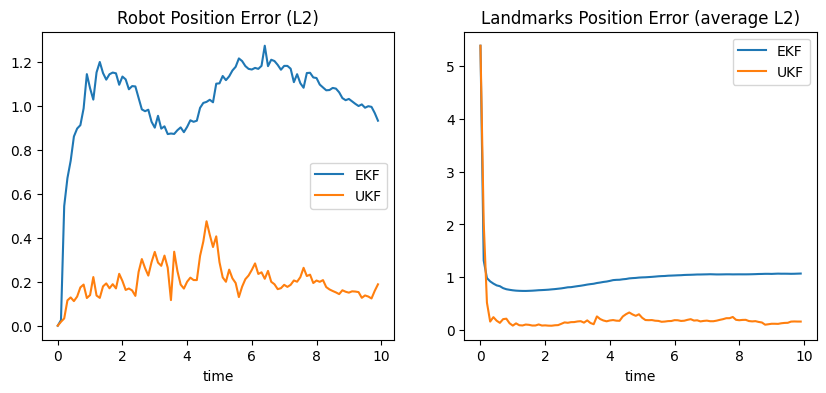

In [79]:
# Error analysis

errors_EKF = means_EKF - states_gt
errors_UKF = means_UKF - states_gt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("Robot Position Error (L2)")
ax1.set_xlabel("time")
ax1.plot(timesteps, np.sqrt(errors_EKF[:, 0]**2 + errors_EKF[:, 1]**2), label="EKF")
ax1.plot(timesteps, np.sqrt(errors_UKF[:, 0]**2 + errors_UKF[:, 1]**2), label="UKF")
ax1.legend()

ax2.set_title("Landmarks Position Error (average L2)")
ax2.set_xlabel("time")
ax2.plot(timesteps, np.mean(np.sqrt(errors_EKF[:, 3::2]**2 + errors_EKF[:, 4::2]**2), axis=1), label="EKF")
ax2.plot(timesteps, np.mean(np.sqrt(errors_UKF[:, 3::2]**2 + errors_UKF[:, 4::2]**2), axis=1), label="UKF")
# ax2.set_yscale("log")
ax2.legend()